In [2]:
# Import required libraries
import gymnasium as gym
import numpy as np
import torch
import json
import os
import matplotlib.pyplot as plt
from PPO import PPO

In [3]:
# Load best hyperparameters from JSON
best_params_path = './best_params_ppo/Pendulum-v1_ppo_best_params.json'

if os.path.exists(best_params_path):
    with open(best_params_path, 'r') as f:
        best_params = json.load(f)
    print(f"Loaded hyperparameters: {best_params}")
else:
    print(f"Hyperparameters file not found at {best_params_path}, using defaults")
    best_params = {}

Loaded hyperparameters: {'gamma': 0.99, 'lr': 0.0003, 'timesteps_per_batch': 2048, 'max_timesteps_per_episode': 200, 'n_updates_per_iteration': 10, 'clip': 0.2, 'c2': 0, 'seed': 42}


In [4]:
# Create environment and instantiate PPO agent
env_name = 'Pendulum-v1'
env = gym.make(env_name)

# Create agent with loaded hyperparameters
agent = PPO(env, **best_params)
agent.disc = False  # Pendulum is continuous

print(f"Agent created for {env_name}")

Successfully set seed to 42
Agent created for Pendulum-v1


In [5]:
# Load saved actor and critic weights
actor_path = './best_params_ppo/Pendulum-v1_ppo_actor.pth'
critic_path = './best_params_ppo/Pendulum-v1_ppo_critic.pth'

if os.path.exists(actor_path):
    agent.actor.load_state_dict(torch.load(actor_path, map_location='cpu'))
    print(f"✓ Loaded actor weights from {actor_path}")
else:
    print(f"✗ Actor weights not found at {actor_path}")

if os.path.exists(critic_path):
    agent.critic.load_state_dict(torch.load(critic_path, map_location='cpu'))
    print(f"✓ Loaded critic weights from {critic_path}")
else:
    print(f"✗ Critic weights not found at {critic_path}")

agent.actor.eval()  # Set to evaluation mode

✓ Loaded actor weights from ./best_params_ppo/Pendulum-v1_ppo_actor.pth
✓ Loaded critic weights from ./best_params_ppo/Pendulum-v1_ppo_critic.pth


Sequential(
  (0): Linear(in_features=3, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=1, bias=True)
  (5): Identity()
)

In [6]:
# Run 100 deterministic test episodes
n_episodes = 100
episode_rewards = []

print(f"Running {n_episodes} test episodes...")

for episode in range(n_episodes):
    obs, _ = env.reset()
    episode_reward = 0.0
    done = False
    
    while not done:
        # Get deterministic action from actor (use mean, no sampling)
        obs_tensor = torch.tensor(obs, dtype=torch.float)
        with torch.no_grad():
            action = agent.actor(obs_tensor).numpy()
        
        # Clip action to environment bounds
        action = np.clip(action, env.action_space.low, env.action_space.high)
        
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
    
    episode_rewards.append(episode_reward)
    
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1}/{n_episodes} complete")

env.close()

print(f"\n✓ Completed {n_episodes} episodes")
print(f"Mean reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")

Running 100 test episodes...
Episode 10/100 complete
Episode 20/100 complete
Episode 30/100 complete
Episode 40/100 complete
Episode 50/100 complete
Episode 60/100 complete
Episode 70/100 complete
Episode 80/100 complete
Episode 90/100 complete
Episode 100/100 complete

✓ Completed 100 episodes
Mean reward: -155.48 ± 158.89


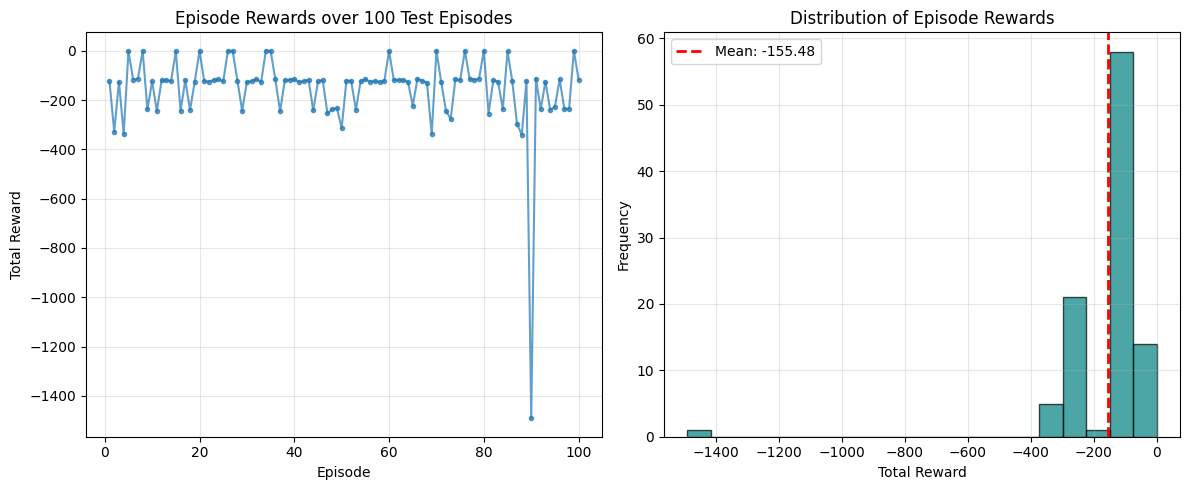


Reward Statistics:
  Min: -1491.09
  Max: -0.01
  Mean: -155.48
  Std: 158.89


In [7]:
# Plot episode rewards
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, n_episodes + 1), episode_rewards, marker='.', linestyle='-', alpha=0.7)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Episode Rewards over 100 Test Episodes')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(episode_rewards, bins=20, color='teal', alpha=0.7, edgecolor='black')
plt.xlabel('Total Reward')
plt.ylabel('Frequency')
plt.title('Distribution of Episode Rewards')
plt.axvline(np.mean(episode_rewards), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(episode_rewards):.2f}')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nReward Statistics:")
print(f"  Min: {np.min(episode_rewards):.2f}")
print(f"  Max: {np.max(episode_rewards):.2f}")
print(f"  Mean: {np.mean(episode_rewards):.2f}")
print(f"  Std: {np.std(episode_rewards):.2f}")

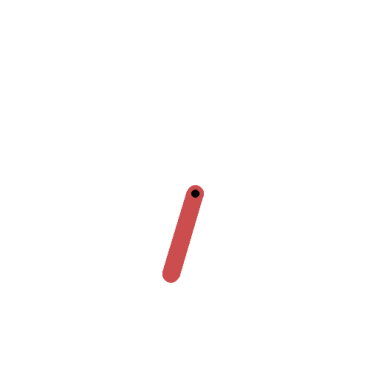

In [8]:
# Record a video of one test episode
video_env = gym.make(env_name, render_mode='rgb_array')
obs, _ = video_env.reset()
done = False
frames = []
while not done:
    frames.append(video_env.render())
    obs_tensor = torch.tensor(obs, dtype=torch.float)
    with torch.no_grad():
        action = agent.actor(obs_tensor).numpy()
    action = np.clip(action, video_env.action_space.low, video_env.action_space.high)
    obs, reward, terminated, truncated, _ = video_env.step(action)
    done = terminated or truncated
video_env.close()
# Save video using matplotlib
import matplotlib.animation as animation
fig = plt.figure()
plt.axis('off')
im = plt.imshow(frames[0])
def update_frame(i):
    im.set_array(frames[i])
    return [im]
ani = animation.FuncAnimation(fig, update_frame, frames=len(frames), interval=50)
# display the video
from IPython.display import HTML
HTML(ani.to_jshtml())
